In [90]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average

In [191]:
sys.path.append("C:\\Users\josep\Downloads")

In [194]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [196]:
list(f.keys())

['DSV_00', 'U', 'Uk', 'eta', 'k', 't', 'x', 'y', 'z']

In [91]:
f = h5py.File('shearing_curr_res_7.5_dt_1.0_T_600_U_1.0exp(0.2z)+0.05_psi_30_smax_10_0_surf3d.hdf5', 'r')

In [92]:
x = f.get('x')
y = f.get('y')
t = f.get('t')

In [4]:
x = np.array(x)
y = np.array(y)
t = np.array(t)

In [5]:
surf3d = surface_core.surface_from_file("shearing_curr_res_7.5_dt_1.0_T_600_U_1.0exp(0.2z)+0.05_psi_30_smax_10_0_surf3d.hdf5")

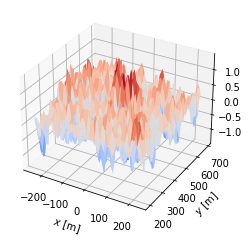

In [6]:
surf3d.plot_3d_surface()
plt.show()

In [7]:
spec3d = surf3d.define_SpectralAnalysis()
spec3d

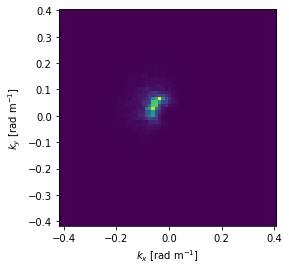

In [8]:
spec3d.plot()

2 2.0001473227855016 191


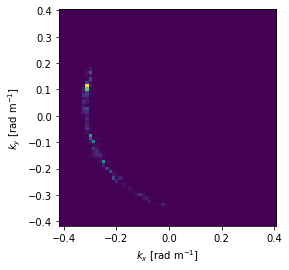

In [9]:
spec3d.plot_w_slice(2)
# Method for 3D, plot kx-ky spectra at a given w

In [10]:
def cart2pol(x, y, cart, Nr=200, Ntheta=360, r_out=None, theta_out=None):
    '''
    Conversion from cartesian to polar coordinates
    Extrapolation possible (can be avoided by setting r_out, theta_out accordingly)
    Parameter:
    ----------
    input:
            x       array
                    1d array of x-axis
            y       array
                    1d array of y-axis
            cart    2d array (dimensions matching x,y, 'ij'-indexing)
                    matrix to be converted
    output:
            r       array
                    1d array of r-axis
            theta   array
                    1d array of theta-axis
            pol     2d array
                    data in polar coordinats
    '''
    xx, yy = np.meshgrid(x, y, indexing='ij')
    theta_cart = np.arctan2(yy, xx)
    r_cart = np.sqrt(xx**2 + yy**2)
    rmin = np.min(r_cart)
    rmax = np.max(r_cart)
    tmin = np.min(theta_cart)
    tmax = np.max(theta_cart)
    if theta_out is None:
        theta = np.linspace(tmin, tmax, Ntheta, endpoint=True)
    else:
        theta = theta_out
        Ntheta = len(theta)
    if r_out is None:
        r = np.linspace(rmin, rmax, Nr, endpoint=True)
    else:
        r = r_out
        Nr = len(r)
    F = RectBivariateSpline(x, y, cart)
    rr, th = np.meshgrid(r, theta, indexing='ij')
    x_pol = rr*np.cos(th)
    y_pol = rr*np.sin(th)
    pol = F(x_pol.ravel(), y_pol.ravel(), grid=False).reshape((Nr, Ntheta))
    return r, theta, pol

In [11]:
def cart2cylindrical(x, y, cart, Nr=200, Ntheta=360):
    '''
    blabla
    polar coordinates in (x,y)
    '''
    r = np.zeros(Nr)
    theta = np.zeros(Ntheta)
    Nt = 600
    cylindrical = np.zeros((Nt, Nr, Ntheta))
    for i in range(0, Nt):
        r, theta, cylindrical[i,:,:] = cart2pol(x, y, cart[i,:,:], Nr, Ntheta)
    return r, theta, cylindrical

In [12]:
def transform_spectrum_to_polar(self, Nr, Ntheta):        
    return polar_coordinates.cart2cylindrical(t, self.kx, self.ky, self.spectrum, Nr=Nr, Ntheta=Ntheta)

In [13]:
spec3d.transform_spectrum_to_polar()

TypeError: cart2cylindrical() missing 1 required positional argument: 'cart'

## Transforming Data to Polars

In [40]:
kx_list = []
ky_list = []
# empty kx and ky lists for triplet values

thresh_freq = 1
max_freq = 2
step_size = 0.1
# Input frequencies values 

freqs = np.arange(thresh_freq, max_freq, step_size)

for f in freqs:
    i = np.argmin(np.abs(spec3d.w[600//2:]-f))
    spec = spec3d.spectrum()
    spec_values = spec[600//2 + i,:,:]
    # Gives the spectrum values represented by colour
    
    max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
    # Finds the specific index of the maximum value in spec_values
    
    max_kx = spec3d.kx[max_index[0]]
    max_ky = spec3d.ky[max_index[1]]
    # Finds the value of kx and ky corresponding to the maximum spectral density 
    
    kx_list.append(max_kx)
    ky_list.append(max_ky)

In [81]:
kx = np.array(kx_list)
kx

array([-0.08885313, -0.11423973, -0.10154643, -0.12693304, -0.16501295,
       -0.19039955, -0.20309286, -0.24117277, -0.26655938, -0.26655938])

In [76]:
ky = np.array(ky_list)
ky

array([ 0.02538661,  0.0126933 ,  0.10154643,  0.10154643, -0.03807991,
        0.02538661,  0.11423973,  0.05077321,  0.05077321, -0.10154643])

In [77]:
r = np.sqrt( (kx)**2 + (ky)**2 )
r

array([0.09240865, 0.11494275, 0.14360834, 0.1625536 , 0.16934979,
       0.19208454, 0.23301808, 0.24645938, 0.27135184, 0.28524652])

In [83]:
theta = np.arctan2(ky,kx)
theta

array([ 2.86329299,  3.03093543,  2.35619449,  2.46685171, -2.91479381,
        3.00904112,  2.62920319,  2.93409643,  2.95337115, -2.7776137 ])

In [93]:
z = f.get('z')
z_list = np.array(z)

In [94]:
U = f.get('U')
U_list = np.array(U)

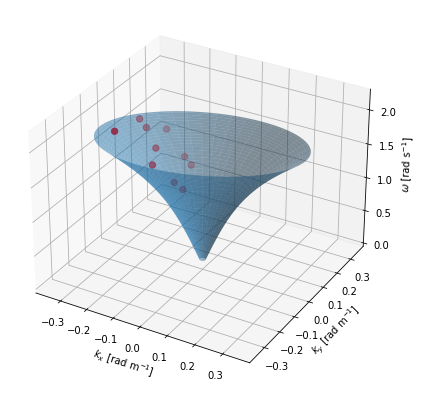

In [104]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')

plotting_interface.plot_disp_shell(axes, h=10, z = z_list, U = U_list, psi = 30)
axes.scatter(r*np.cos(theta), r*np.sin(theta), freqs, color='red', s=40)

In [109]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww

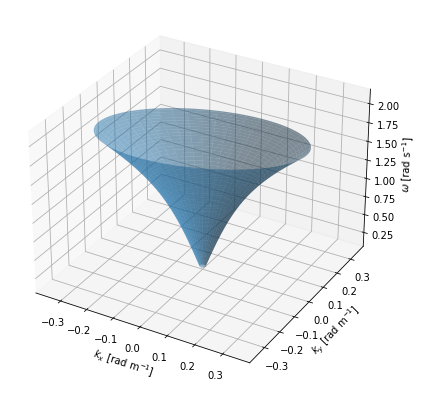

In [115]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h=10, z = z_list, U = U_list, psi = 30)

In [125]:
disp_kx

array([[0.01      , 0.0099875 , 0.00995004, ..., 0.00996542, 0.00999449,
        0.00999859],
       [0.015     , 0.01498125, 0.01492506, ..., 0.01494813, 0.01499174,
        0.01499788],
       [0.02      , 0.01997501, 0.01990008, ..., 0.01993084, 0.01998899,
        0.01999717],
       ...,
       [0.335     , 0.33458134, 0.3333264 , ..., 0.3338416 , 0.33481556,
        0.33495264],
       [0.34      , 0.33957509, 0.33830142, ..., 0.33882431, 0.3398128 ,
        0.33995194],
       [0.345     , 0.34456884, 0.34327644, ..., 0.34380702, 0.34481005,
        0.34495123]])

In [120]:
disp_ky.shape

(68, 127)

In [121]:
disp_ww.shape

(68, 127)

In [163]:
matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
matrix_disp_r

array([[0.01 , 0.01 , 0.01 , ..., 0.01 , 0.01 , 0.01 ],
       [0.015, 0.015, 0.015, ..., 0.015, 0.015, 0.015],
       [0.02 , 0.02 , 0.02 , ..., 0.02 , 0.02 , 0.02 ],
       ...,
       [0.335, 0.335, 0.335, ..., 0.335, 0.335, 0.335],
       [0.34 , 0.34 , 0.34 , ..., 0.34 , 0.34 , 0.34 ],
       [0.345, 0.345, 0.345, ..., 0.345, 0.345, 0.345]])

In [158]:
disp_r = matrix_disp_r[:,0]
disp_r

array([0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.2  , 0.205, 0.21 , 0.215, 0.22 , 0.225, 0.23 ,
       0.235, 0.24 , 0.245, 0.25 , 0.255, 0.26 , 0.265, 0.27 , 0.275,
       0.28 , 0.285, 0.29 , 0.295, 0.3  , 0.305, 0.31 , 0.315, 0.32 ,
       0.325, 0.33 , 0.335, 0.34 , 0.345])

In [161]:
matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
matrix_disp_theta

array([[ 0.        ,  0.05      ,  0.1       , ..., -0.08318531,
        -0.03318531,  0.01681469],
       [ 0.        ,  0.05      ,  0.1       , ..., -0.08318531,
        -0.03318531,  0.01681469],
       [ 0.        ,  0.05      ,  0.1       , ..., -0.08318531,
        -0.03318531,  0.01681469],
       ...,
       [ 0.        ,  0.05      ,  0.1       , ..., -0.08318531,
        -0.03318531,  0.01681469],
       [ 0.        ,  0.05      ,  0.1       , ..., -0.08318531,
        -0.03318531,  0.01681469],
       [ 0.        ,  0.05      ,  0.1       , ..., -0.08318531,
        -0.03318531,  0.01681469]])

In [154]:
disp_theta = matrix_disp_theta[0]
disp_theta

array([ 0.        ,  0.05      ,  0.1       ,  0.15      ,  0.2       ,
        0.25      ,  0.3       ,  0.35      ,  0.4       ,  0.45      ,
        0.5       ,  0.55      ,  0.6       ,  0.65      ,  0.7       ,
        0.75      ,  0.8       ,  0.85      ,  0.9       ,  0.95      ,
        1.        ,  1.05      ,  1.1       ,  1.15      ,  1.2       ,
        1.25      ,  1.3       ,  1.35      ,  1.4       ,  1.45      ,
        1.5       ,  1.55      ,  1.6       ,  1.65      ,  1.7       ,
        1.75      ,  1.8       ,  1.85      ,  1.9       ,  1.95      ,
        2.        ,  2.05      ,  2.1       ,  2.15      ,  2.2       ,
        2.25      ,  2.3       ,  2.35      ,  2.4       ,  2.45      ,
        2.5       ,  2.55      ,  2.6       ,  2.65      ,  2.7       ,
        2.75      ,  2.8       ,  2.85      ,  2.9       ,  2.95      ,
        3.        ,  3.05      ,  3.1       , -3.13318531, -3.08318531,
       -3.03318531, -2.98318531, -2.93318531, -2.88318531, -2.83

In [174]:
disp_theta.shape

(127,)

In [166]:
disp_ww[:,0].shape

(68,)

In [198]:
disp_ww

array([[0.09904826, 0.09899447, 0.0989404 , ..., 0.09913676, 0.09908374,
        0.09903021],
       [0.14837361, 0.14825835, 0.14814248, ..., 0.14856325, 0.14844964,
        0.14833494],
       [0.19739524, 0.19719969, 0.19700311, ..., 0.19771696, 0.19752421,
        0.19732962],
       ...,
       [1.85675636, 1.84192225, 1.82700984, ..., 1.88116229, 1.86654044,
        1.85177878],
       [1.87131635, 1.856198  , 1.84099985, ..., 1.89618992, 1.88128791,
        1.86624339],
       [1.88576305, 1.8703596 , 1.85487486, ..., 1.91110568, 1.89592265,
        1.88059443]])

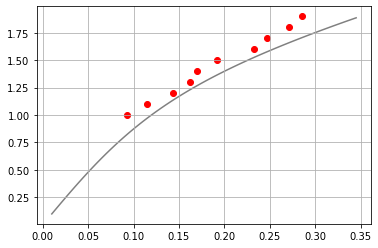

In [185]:
plt.scatter(r,z, color = 'red', zorder=1)
plt.plot(disp_r,disp_ww[:,0], color='grey',zorder=0)
plt.grid(True)

## Make Into Function 

In [234]:
def plot_disp_relation_and_points_at_theta(spec_theta, thresh_freq, max_freq, step_size, h, z, U, psi):
    '''
    This function finds the relationship between triplets found from spectrum from FFT 
    and the dispersion relation at specific theta. 
    It plots it in the Radial vs Omega Space. 
    '''
    
    # (1) TRIPLET POINTS
    
    freqs = np.arange(thresh_freq, max_freq, step_size)
    kx_list = []
    ky_list = []

    # This gets the triplets points 
    # Triplets are (max_kx, mak_ky, freqs)
    for f in freqs:
        i = np.argmin(np.abs(spec3d.w[600//2:]-f))
        spec = spec3d.spectrum()
        spec_values = spec[600//2 + i,:,:]
        # Gives the spectrum values represented by colour
    
        max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
        # Finds the specific index of the maximum value in spec_values
    
        max_kx = spec3d.kx[max_index[0]]
        max_ky = spec3d.ky[max_index[1]]
        # Finds the value of kx and ky corresponding to the maximum spectral density 
        
        kx_list.append(max_kx)
        ky_list.append(max_ky)
        
    kx = np.array(kx_list)
    ky = np.array(ky_list)
    
    # transform Triplets to polar coordinates
    r = np.sqrt( (kx)**2 + (ky)**2 )
    theta = np.arctan2(ky,kx)
    
    # (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h, z, U, psi = 30)
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]
    
    plt.scatter(r, freqs, color = 'red', zorder=1, label = 'Triplets')
    plt.plot(disp_r,disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation vs Triplets in Radial-Frequency Space")
    plt.legend()

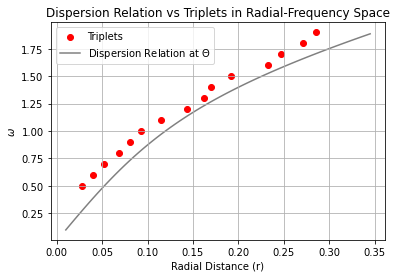

In [235]:
plot_disp_relation_and_points_at_theta(0, thresh_freq = 0.5 , max_freq = 2, step_size = 0.1, h=10, z = z_list, U = U_list, psi = 30)

In [96]:
z = freqs
z

array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])

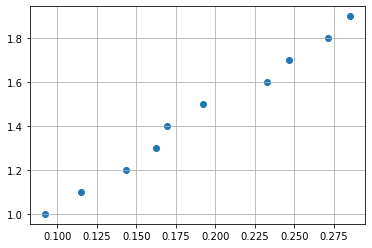

In [101]:
plt.scatter(r,z)
plt.grid(True)

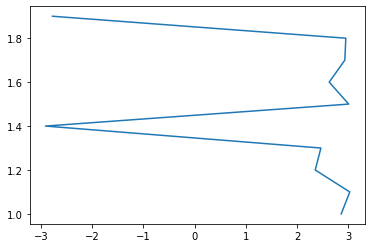

In [98]:
plt.plot(theta,z)

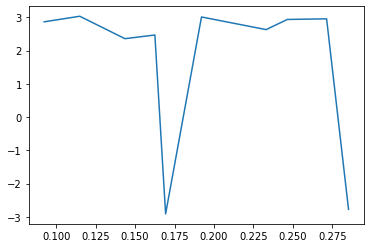

In [102]:
plt.plot(r,theta)

In [34]:
r, theta, spec_pol = polar_coordinates.cart2cylindrical(t, spec3d.kx, spec3d.ky, spec3d.spectrum(), Ntheta=200)
# Transforms data into polar co-ordiantes

In [25]:
r

array([0.        , 0.00297681, 0.00595361, 0.00893042, 0.01190722,
       0.01488403, 0.01786084, 0.02083764, 0.02381445, 0.02679125,
       0.02976806, 0.03274487, 0.03572167, 0.03869848, 0.04167528,
       0.04465209, 0.0476289 , 0.0506057 , 0.05358251, 0.05655931,
       0.05953612, 0.06251293, 0.06548973, 0.06846654, 0.07144334,
       0.07442015, 0.07739696, 0.08037376, 0.08335057, 0.08632737,
       0.08930418, 0.09228099, 0.09525779, 0.0982346 , 0.1012114 ,
       0.10418821, 0.10716502, 0.11014182, 0.11311863, 0.11609543,
       0.11907224, 0.12204905, 0.12502585, 0.12800266, 0.13097946,
       0.13395627, 0.13693308, 0.13990988, 0.14288669, 0.14586349,
       0.1488403 , 0.15181711, 0.15479391, 0.15777072, 0.16074752,
       0.16372433, 0.16670114, 0.16967794, 0.17265475, 0.17563155,
       0.17860836, 0.18158517, 0.18456197, 0.18753878, 0.19051558,
       0.19349239, 0.1964692 , 0.199446  , 0.20242281, 0.20539961,
       0.20837642, 0.21135323, 0.21433003, 0.21730684, 0.22028

In [26]:
theta

array([-3.11129889e+00, -3.07987733e+00, -3.04845576e+00, -3.01703420e+00,
       -2.98561263e+00, -2.95419107e+00, -2.92276950e+00, -2.89134793e+00,
       -2.85992637e+00, -2.82850480e+00, -2.79708324e+00, -2.76566167e+00,
       -2.73424011e+00, -2.70281854e+00, -2.67139698e+00, -2.63997541e+00,
       -2.60855384e+00, -2.57713228e+00, -2.54571071e+00, -2.51428915e+00,
       -2.48286758e+00, -2.45144602e+00, -2.42002445e+00, -2.38860289e+00,
       -2.35718132e+00, -2.32575975e+00, -2.29433819e+00, -2.26291662e+00,
       -2.23149506e+00, -2.20007349e+00, -2.16865193e+00, -2.13723036e+00,
       -2.10580880e+00, -2.07438723e+00, -2.04296566e+00, -2.01154410e+00,
       -1.98012253e+00, -1.94870097e+00, -1.91727940e+00, -1.88585784e+00,
       -1.85443627e+00, -1.82301471e+00, -1.79159314e+00, -1.76017157e+00,
       -1.72875001e+00, -1.69732844e+00, -1.66590688e+00, -1.63448531e+00,
       -1.60306375e+00, -1.57164218e+00, -1.54022062e+00, -1.50879905e+00,
       -1.47737748e+00, -

In [27]:
r.shape

(200,)

In [28]:
theta.shape

(200,)

In [32]:
spec3d.kx

array([-0.41887902, -0.40618572, -0.39349241, -0.38079911, -0.36810581,
       -0.3554125 , -0.3427192 , -0.33002589, -0.31733259, -0.30463929,
       -0.29194598, -0.27925268, -0.26655938, -0.25386607, -0.24117277,
       -0.22847947, -0.21578616, -0.20309286, -0.19039955, -0.17770625,
       -0.16501295, -0.15231964, -0.13962634, -0.12693304, -0.11423973,
       -0.10154643, -0.08885313, -0.07615982, -0.06346652, -0.05077321,
       -0.03807991, -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,
        0.02538661,  0.03807991,  0.05077321,  0.06346652,  0.07615982,
        0.08885313,  0.10154643,  0.11423973,  0.12693304,  0.13962634,
        0.15231964,  0.16501295,  0.17770625,  0.19039955,  0.20309286,
        0.21578616,  0.22847947,  0.24117277,  0.25386607,  0.26655938,
        0.27925268,  0.29194598,  0.30463929,  0.31733259,  0.33002589,
        0.3427192 ,  0.3554125 ,  0.36810581,  0.38079911,  0.39349241,
        0.40618572])

In [37]:
kx_list = []
ky_list = []
# empty kx and ky lists for triplet values

thresh_freq = 1
max_freq = 2
step_size = 0.1
# Input frequencies values 

freqs = np.arange(thresh_freq, max_freq, step_size)

for f in freqs:
    i = np.argmin(np.abs(spec3d.w[600//2:]-f))
    spec = spec_pol
    spec_values = spec[600//2 + i,:,:]
    # Gives the spectrum values represented by colour
    
    max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
    # Finds the specific index of the maximum value in spec_values
    
    max_r = r[max_index[0]]
    max_theta = theta[max_index[1]]
    # Finds the value of kx and ky corresponding to the maximum spectral density 
    
    kx_list.append(max_r)
    ky_list.append(max_theta)

In [39]:
max_theta

-2.765661672465647

In [29]:
spec_pol.shape

(600, 200, 200)

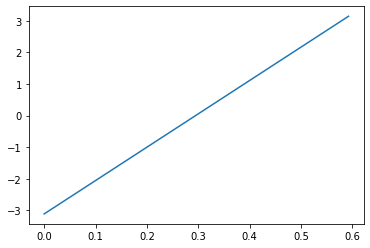

In [31]:
plt.plot(r,theta)